In [1]:
# Import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import json
from io import BytesIO
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"OpenCV version: {cv2.__version__}")

✅ Libraries imported successfully!
PyTorch version: 2.6.0+cpu
OpenCV version: 4.10.0


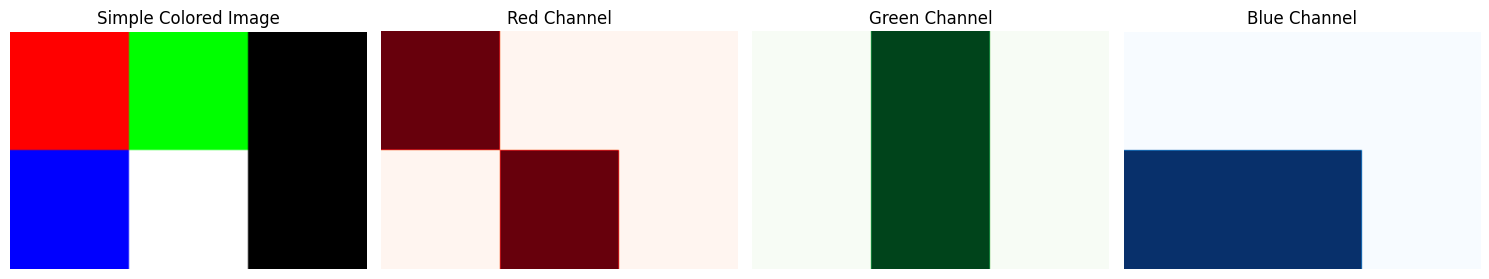

Image shape: (100, 150, 3)
Data type: uint8
Min value: 0
Max value: 255
Memory usage: 45000 bytes


In [2]:
import numpy as np
import matplotlib.pyplot as plt

height, width = 100, 150
simple_image = np.zeros((height, width, 3), dtype=np.uint8)

# Add colored regions
# Red square in top-left
simple_image[:50, :50, 0] = 255               # Red channel
# Green square in top-right
simple_image[:50, 50:100, 1] = 255            # Green channel
# Blue square in bottom-left
simple_image[50:, :50, 2] = 255               # Blue channel
# White square in bottom-right
simple_image[50:, 50:100, :] = 255            # All channels (white)

# Visualize and analyze
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(simple_image)
plt.title('Simple Colored Image')
plt.axis('off')

# Show individual color channels
channels = ['Red', 'Green', 'Blue']
cmaps    = ['Reds', 'Greens', 'Blues']

for i, (ch, cmap) in enumerate(zip(channels, cmaps)):
    plt.subplot(1, 4, i+2)
    plt.imshow(simple_image[:, :, i], cmap=cmap)   # Select the appropriate channel index (0=R, 1=G, 2=B)
    plt.title(f'{ch} Channel')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print image properties
print(f"Image shape: {simple_image.shape}")         # (100, 150, 3)
print(f"Data type: {simple_image.dtype}")           # uint8
print(f"Min value: {simple_image.min()}")           # 0
print(f"Max value: {simple_image.max()}")           # 255
print(f"Memory usage: {simple_image.nbytes} bytes")


📥 Loading sample image...
✅ Image downloaded successfully!


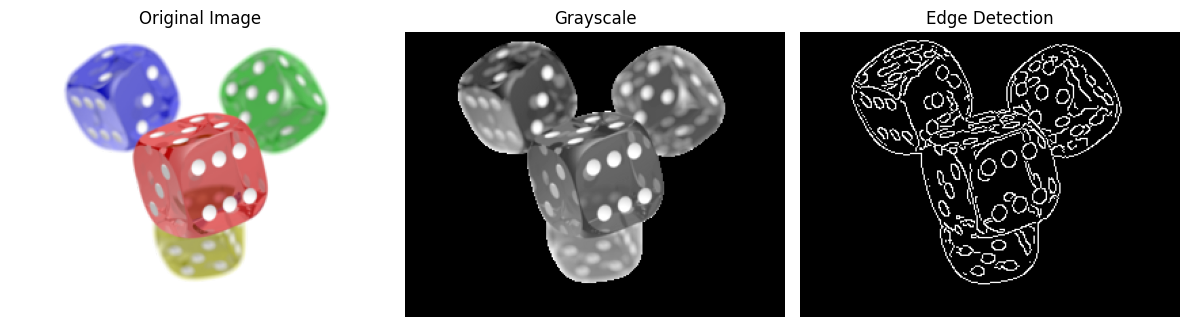

Original shape: (210, 280, 4)
Grayscale shape: (210, 280)
Pixel value range: 0 to 255


In [3]:
def download_image(url, filename):
    """Download an image from URL"""
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        return image
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

# Sample image URLs (feel free to replace with your own)
sample_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/280px-PNG_transparency_demonstration_1.png",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Vd-Orig.png/256px-Vd-Orig.png"
]

# TODO: Try to download an image, or create a sample if download fails
print("📥 Loading sample image...")
try:
    sample_image = download_image(sample_urls[0], "sample.png")
    if sample_image is None:
        raise Exception("Download failed")
    print("✅ Image downloaded successfully!")
except:
    print("📁 Creating local sample image...")
    # Create a more complex sample image
    sample_array = np.random.randint(0, 256, (200, 300, 3), dtype=np.uint8)
    # Add some patterns
    cv2.circle(sample_array, (150, 100), 50, (255, 0, 0), -1)  # Blue circle
    cv2.rectangle(sample_array, (50, 50), (100, 150), (0, 255, 0), -1)  # Green rectangle
    sample_image = Image.fromarray(sample_array)
    print("✅ Sample image created!")

# Convert to numpy for analysis
img_array = np.array(sample_image)

# TODO: Display and analyze the image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_array)
plt.title('Original Image')
plt.axis('off')

# TODO: Convert to grayscale
gray_image = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)  # Use cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

# TODO: Apply edge detection
edges = cv2.Canny(gray_image, 50, 150)  # Use cv2.Canny(gray_image, 50, 150)
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

# TODO: Print image statistics
print(f"Original shape: {img_array.shape}")  # img_array.shape
print(f"Grayscale shape: {gray_image.shape}")  # gray_image.shape
print(f"Pixel value range: {img_array.min()} to {img_array.max()}")

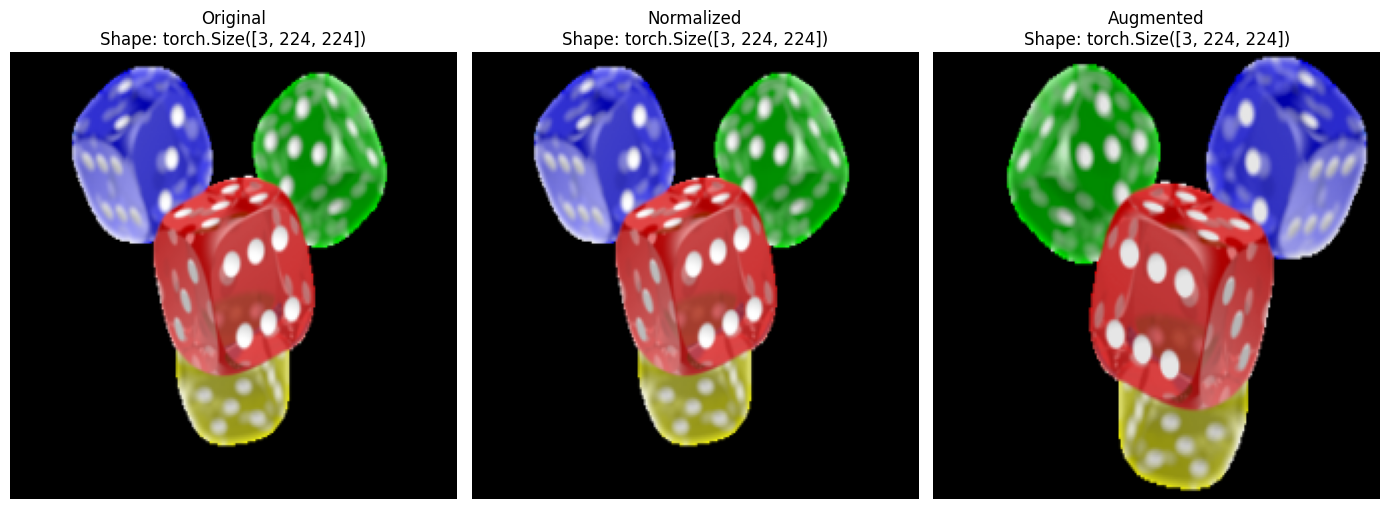

🔍 Transformation Analysis:
Original     - Shape: torch.Size([3, 224, 224]), Range: [0.000, 1.000]
Normalized   - Shape: torch.Size([3, 224, 224]), Range: [-2.118, 2.640]
Augmented    - Shape: torch.Size([3, 224, 224]), Range: [-2.101, 2.535]


In [7]:
transformations = {
    'Original': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'Normalized': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Augmented': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

plt.figure(figsize=(14, 5))

for i, (name, transform) in enumerate(transformations.items()):
    # Ensure image is RGB
    img = sample_image.convert('RGB') if sample_image.mode != 'RGB' else sample_image

    # Apply transformation
    transformed = transform(img)

    plt.subplot(1, 3, i + 1)

    # Convert tensor to displayable image
    if name == 'Original':
        # Permute from (C, H, W) to (H, W, C)
        display_img = transformed.permute(1, 2, 0).numpy()
    else:
        # Denormalize if normalized/augmented
        display_img = transformed.clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        display_img = display_img * std + mean  # Denormalize
        display_img = display_img.permute(1, 2, 0).numpy()
        display_img = np.clip(display_img, 0, 1)  # Clamp to valid range

    plt.imshow(display_img)
    plt.title(f'{name}\nShape: {transformed.shape}')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("🔍 Transformation Analysis:")
for name, transform in transformations.items():
    img = sample_image.convert('RGB') if sample_image.mode != 'RGB' else sample_image
    tensor = transform(img)
    print(f"{name:12} - Shape: {tensor.shape}, Range: [{tensor.min():.3f}, {tensor.max():.3f}]")


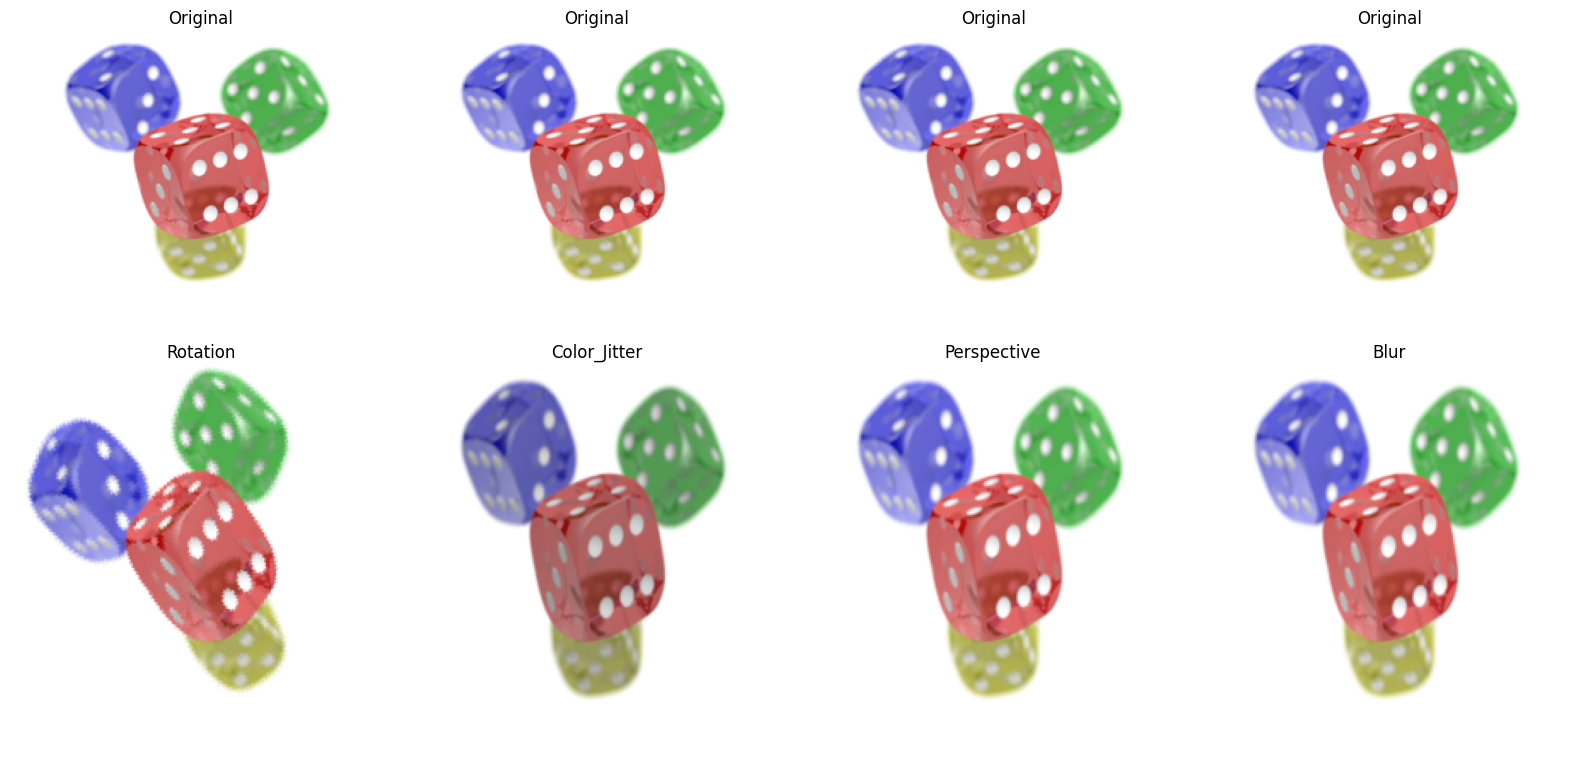

🤔 Discussion Questions:
• Which augmentations preserve the image's meaning?
• Which might be problematic for certain tasks (e.g., text recognition)?
• How might you choose augmentations for a medical imaging task?


In [8]:
augmentation_examples = {
    'Rotation': transforms.Compose([
        transforms.Resize((224, 224)),
        # TODO: Add rotation transform
        transforms.RandomRotation(degrees=30),  # Try degrees=30
        transforms.ToTensor()
    ]),
    
    'Color_Jitter': transforms.Compose([
        transforms.Resize((224, 224)),
        # TODO: Add color jitter
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Try 0.3, 0.3, 0.3
        transforms.ToTensor()
    ]),
    
    'Perspective': transforms.Compose([
        transforms.Resize((224, 224)),
        # TODO: Add perspective transform
        transforms.RandomPerspective(distortion_scale=0.3),  # Try 0.3
        transforms.ToTensor()
    ]),
    
    'Blur': transforms.Compose([
        transforms.Resize((224, 224)),
        # TODO: Add blur transform
        transforms.GaussianBlur(kernel_size=5),  # Try 5
        transforms.ToTensor()
    ])
}

# TODO: Show multiple augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, (name, transform) in enumerate(augmentation_examples.items()):
    # Show original
    axes[0, i].imshow(sample_image)
    axes[0, i].set_title(f'Original')
    axes[0, i].axis('off')
    
    # Show augmented
    augmented = transform(sample_image)
    axes[1, i].imshow(augmented.permute(1, 2, 0))
    axes[1, i].set_title(f'{name}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("🤔 Discussion Questions:")
print("• Which augmentations preserve the image's meaning?")
print("• Which might be problematic for certain tasks (e.g., text recognition)?")
print("• How might you choose augmentations for a medical imaging task?")

In [9]:

print("🔄 Loading pre-trained ResNet-18 model...")
model = models.resnet18(pretrained=True)

# Set model to evaluation mode
model.eval()

print("✅ ResNet-18 model loaded successfully!")

# Analyze model architecture
print("\n🏗️ Model Architecture Analysis:")
print(f"Model type: {type(model).__name__}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params / 1e6:.1f}M parameters")

# Print model structure
print("\n📋 Model Layers (first few):")
layer_count = 0
for name, module in model.named_modules():
    if layer_count < 10:
        print(f"{name}: {type(module).__name__}")
        layer_count += 1
print("... (more layers)")


🔄 Loading pre-trained ResNet-18 model...


c:\Users\Sarthak\OneDrive\Documents\Desktop\Python projects\genai-workshop\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sarthak\OneDrive\Documents\Desktop\Python projects\genai-workshop\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Sarthak/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.17MB/s]

✅ ResNet-18 model loaded successfully!

🏗️ Model Architecture Analysis:
Model type: ResNet
Total parameters: 11,689,512
Trainable parameters: 11,689,512
Model size: ~11.7M parameters

📋 Model Layers (first few):
: ResNet
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1: Sequential
layer1.0: BasicBlock
layer1.0.conv1: Conv2d
layer1.0.bn1: BatchNorm2d
layer1.0.relu: ReLU
... (more layers)


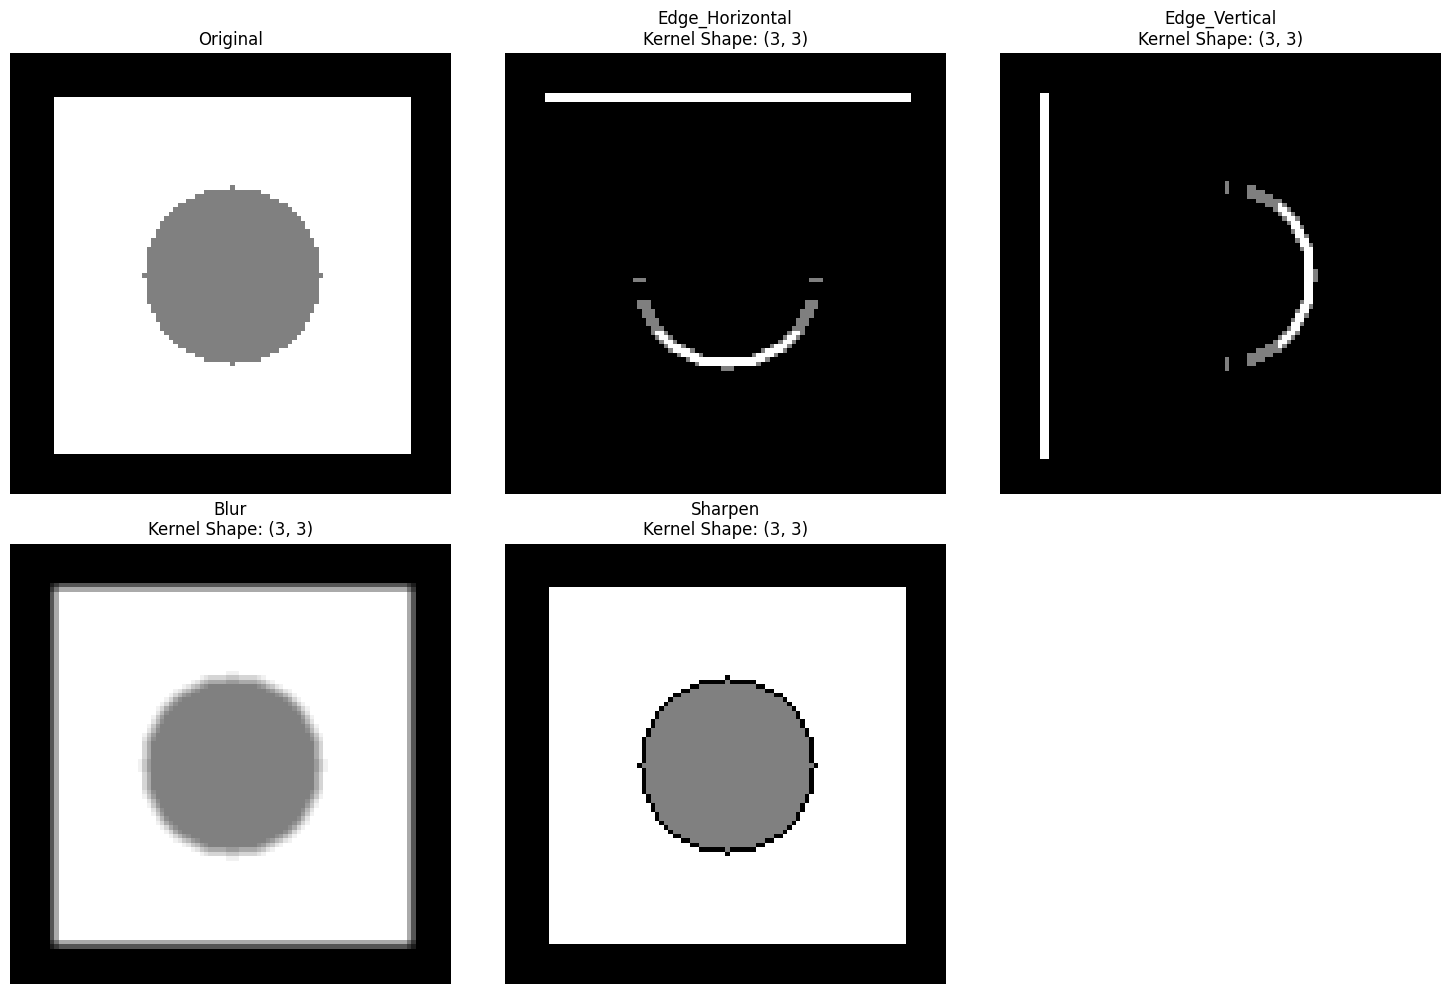

🔍 Convolution Analysis:
• Notice how different kernels detect different features
• CNNs learn these kernels automatically during training
• Deeper layers combine features to detect complex patterns


In [10]:
def visualize_convolution(image, kernel):
    """Apply convolution and visualize the result"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply convolution
    result = cv2.filter2D(image, -1, kernel)
    return result

# Define different convolution kernels
kernels = {
    'Edge_Horizontal': np.array([[-1, -1, -1],
                                 [ 0,  0,  0],
                                 [ 1,  1,  1]]),
    'Edge_Vertical': np.array([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]]),
    # Blur: all elements 1/9 for box blur
    'Blur': np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]]) / 9,
    # Sharpen: center 5, others -1 or 0
    'Sharpen': np.array([[ 0, -1,  0],
                         [-1,  5, -1],
                         [ 0, -1,  0]])
}

# Load or create a sample image and ensure it's RGB
# sample_image = Image.open('your_image.jpg').convert('RGB')
# For demonstration, create a synthetic grayscale image with simple patterns:
sample_image = np.zeros((100, 100, 3), dtype=np.uint8)
cv2.rectangle(sample_image, (10, 10), (90, 90), (255, 255, 255), -1)
cv2.circle(sample_image, (50, 50), 20, (128, 128, 128), -1)

# Convert to grayscale for convolution
gray_sample = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(gray_sample, cmap='gray')
plt.title('Original')
plt.axis('off')

# Apply each kernel and visualize
for i, (name, kernel) in enumerate(kernels.items(), 2):
    result = visualize_convolution(gray_sample, kernel)
    plt.subplot(2, 3, i)
    plt.imshow(result, cmap='gray')
    plt.title(f'{name}\nKernel Shape: {kernel.shape}')
    plt.axis('off')

plt.tight_layout()
plt.show()

print("🔍 Convolution Analysis:")
print("• Notice how different kernels detect different features")
print("• CNNs learn these kernels automatically during training")
print("• Deeper layers combine features to detect complex patterns")
